In [29]:
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Set a professional plot style
sns.set_theme(style="whitegrid")

# Ignore UserWarning from pandas about SQLAlchemy
warnings.filterwarnings("ignore", category=UserWarning)

print("Libraries imported and settings configured.")

Libraries imported and settings configured.


In [30]:
# --- Database Connection Configuration ---
config = {
    'host': '127.0.0.1',
    'user': 'root',
    'password': 'root',
    'database': 'spherych_devapp'
}

# --- CORRECTED SQL QUERY ---
# We are now fetching 'dob' to reliably calculate the age ourselves.
query = """
SELECT
    w.id AS workout_id,
    w.score,
    w.completedWorkout,
    w.measuredDuration AS duration,
    rc.difficulty,
    u.id AS userId,
    u.username,
    hd.dob,  -- THIS IS THE KEY CHANGE: Fetching date of birth
    hd.weight,
    hd.height
FROM
    RaceConfigs rc
JOIN
    Workouts w ON rc.workoutId = w.id
JOIN
    Users u ON w.userId = u.id
LEFT JOIN
    HealthData hd ON u.id = hd.userId
"""

df = None
try:
    print("Connecting to the database...")
    conn = mysql.connector.connect(**config)
    df = pd.read_sql(query, conn)
    print(f"Successfully extracted {len(df)} comprehensive records for the Racer game.")
except mysql.connector.Error as err:
    print(f"Database Error: {err}")
finally:
    if 'conn' in locals() and conn.is_connected():
        conn.close()
        print("Database connection closed.")

if df is not None:
    display(df.head())

Connecting to the database...
Successfully extracted 15616 comprehensive records for the Racer game.
Database connection closed.


,workout_id,score,completedWorkout,duration,difficulty,userId,username,dob,weight,height
0,13,37600,1,299.1150,2,2,Sörde Tschänig,1987-08-24,70.0,180.0
1,14,29710,1,214.7410,2,2,Sörde Tschänig,1987-08-24,70.0,180.0
2,15,400,1,22.8907,2,2,Sörde Tschänig,1987-08-24,70.0,180.0
3,18,950,1,26.9227,2,2,Sörde Tschänig,1987-08-24,70.0,180.0
4,19,700,1,26.9653,2,2,Sörde Tschänig,1987-08-24,70.0,180.0


In [31]:
if df is not None:
    # --- Data Cleaning ---
    original_rows = len(df)
    df_cleaned = df[(df['score'] > 0) & (df['completedWorkout'] == 1)].copy()
    print(f"Removed {original_rows - len(df_cleaned)} records with 0 score or from incomplete workouts.")

    # --- Feature Engineering: Calculate Age from Date of Birth ---
    # Convert 'dob' column to datetime objects. Invalid dates will become NaT (Not a Time).
    dob_datetime = pd.to_datetime(df_cleaned['dob'], errors='coerce')
    
    # Calculate age in years from the datetime objects.
    df_cleaned['age'] = (pd.to_datetime('today') - dob_datetime).dt.days / 365.25
    
    # We can now drop the original 'dob' column as it's been replaced by the 'age' column.
    df_cleaned = df_cleaned.drop(columns=['dob'])

    print(f"\nSuccessfully created a new 'age' column from 'dob'.")
    print(f"Remaining records for analysis: {len(df_cleaned)}")

    print("\n" + "="*60 + "\n")
    print("--- Summary Statistics (Including new 'age' column) ---")
    display(df_cleaned.describe())

Removed 4168 records with 0 score or from incomplete workouts.

Successfully created a new 'age' column from 'dob'.
Remaining records for analysis: 11448


--- Summary Statistics (Including new 'age' column) ---


,workout_id,score,completedWorkout,duration,difficulty,userId,weight,height,age
count,11448.000000,1.144800e+04,11448.0,11448.000000,11448.000000,11448.000000,9764.000000,9717.000000,9451.000000
mean,7866.593117,1.936351e+05,1.0,555.448065,0.636705,407.117138,76.907313,172.366265,44.921897
std,4370.597435,1.973387e+05,0.0,369.385612,1.385635,253.798667,21.973602,15.680645,14.566403
min,2.000000,1.000000e+00,1.0,14.978600,-1.000000,2.000000,0.000000,0.000000,0.733744
25%,4284.750000,5.204125e+04,1.0,300.949000,-1.000000,137.000000,65.000000,165.000000,34.661191
50%,8019.500000,1.296430e+05,1.0,599.328000,1.000000,523.000000,75.000000,173.000000,44.095825
75%,11437.250000,2.833750e+05,1.0,604.715000,2.000000,602.000000,83.000000,180.000000,55.770021
max,15747.000000,1.395700e+06,1.0,1823.340000,2.000000,854.000000,195.000000,198.000000,77.314168


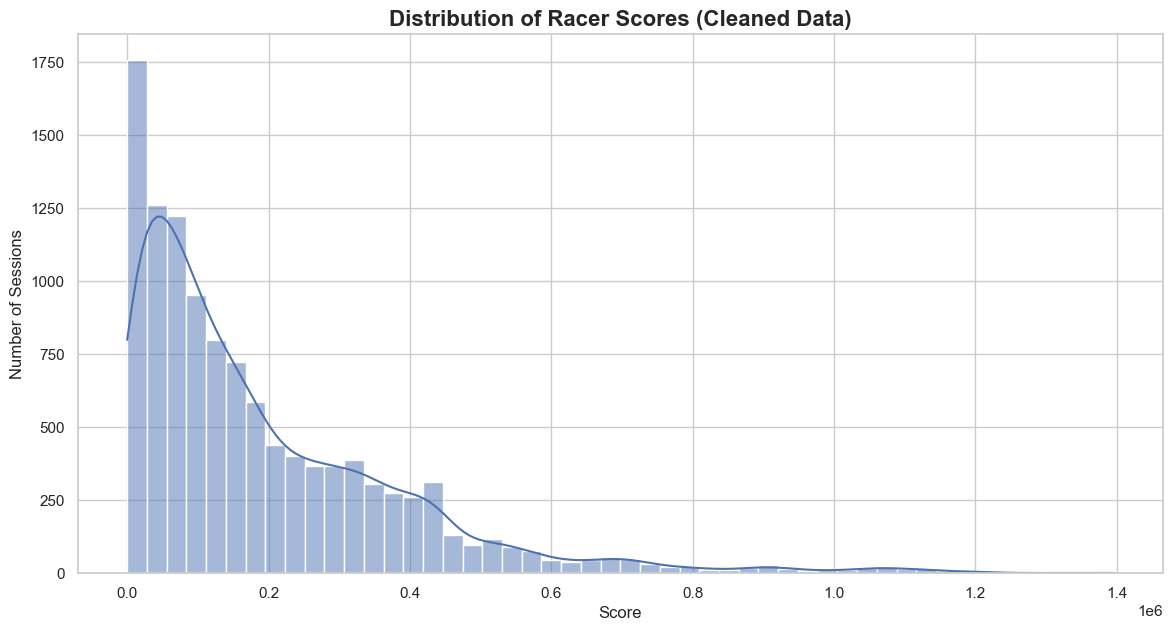

In [32]:
if 'df_cleaned' in locals():
    plt.figure(figsize=(14, 7))
    sns.histplot(df_cleaned['score'], bins=50, kde=True)
    plt.title('Distribution of Racer Scores (Cleaned Data)', fontsize=16, weight='bold')
    plt.xlabel('Score')
    plt.ylabel('Number of Sessions')
    plt.show()

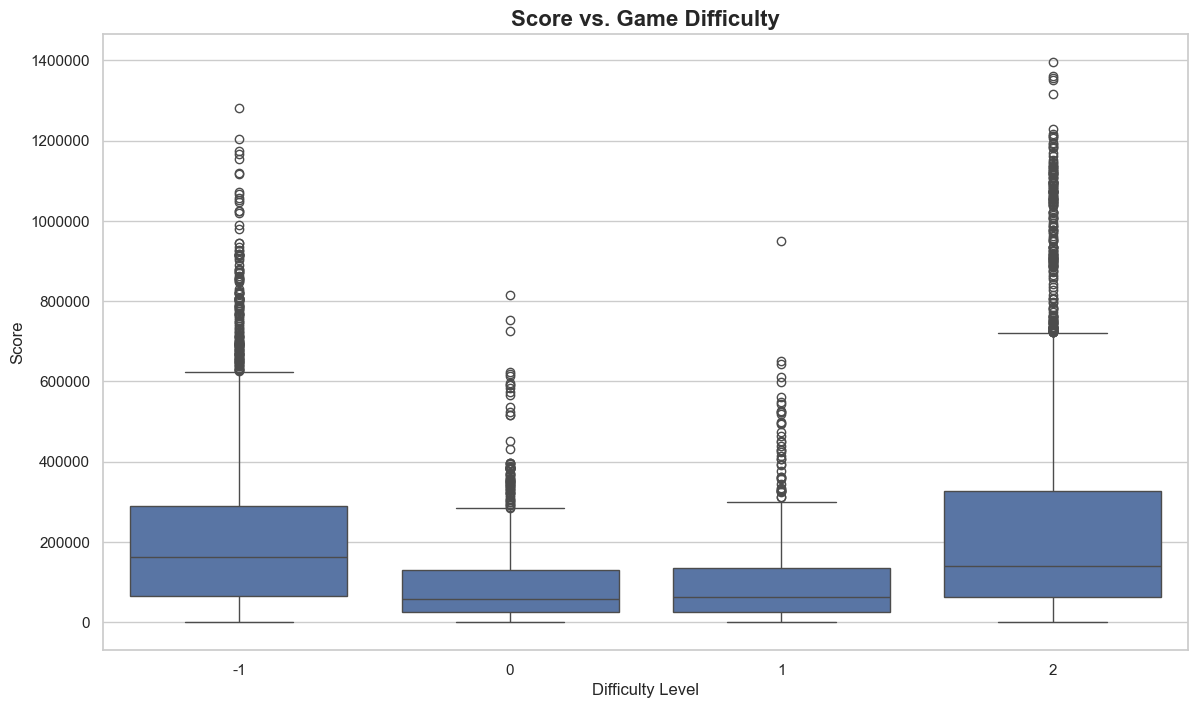

In [33]:
if 'df_cleaned' in locals():
    plt.figure(figsize=(14, 8))
    sns.boxplot(x='difficulty', y='score', data=df_cleaned)
    plt.title('Score vs. Game Difficulty', fontsize=16, weight='bold')
    plt.xlabel('Difficulty Level')
    plt.ylabel('Score')
    plt.ticklabel_format(style='plain', axis='y')
    plt.show()

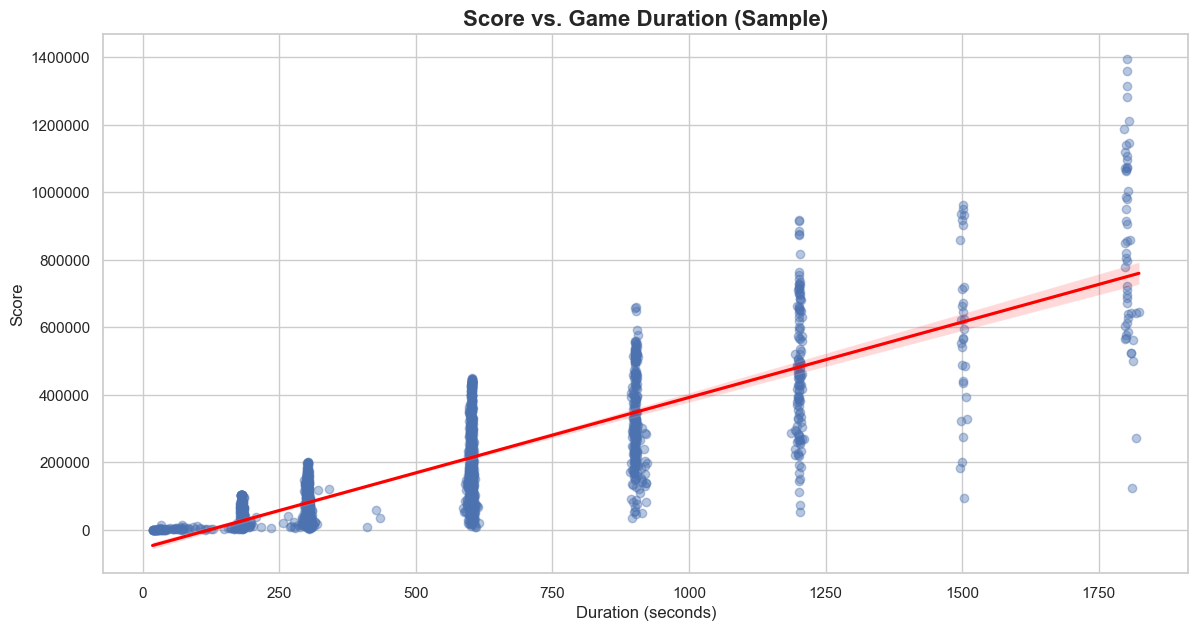

In [34]:
if 'df_cleaned' in locals():
    sample_df = df_cleaned.sample(n=min(2000, len(df_cleaned)), random_state=42)
    plt.figure(figsize=(14, 7))
    sns.regplot(x='duration', y='score', data=sample_df,
                scatter_kws={'alpha':0.4}, line_kws={"color": "red"})
    plt.title('Score vs. Game Duration (Sample)', fontsize=16, weight='bold')
    plt.xlabel('Duration (seconds)')
    plt.ylabel('Score')
    plt.ticklabel_format(style='plain', axis='y')
    plt.show()


--- Analyzing 9451 records with available age data ---


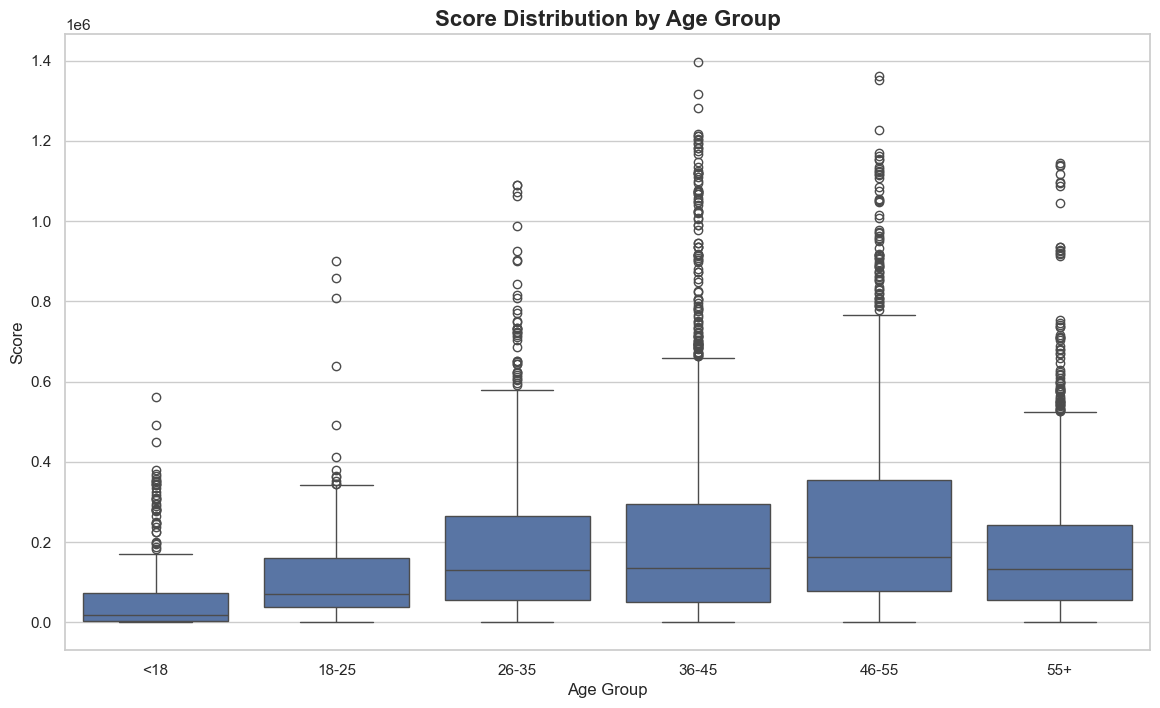

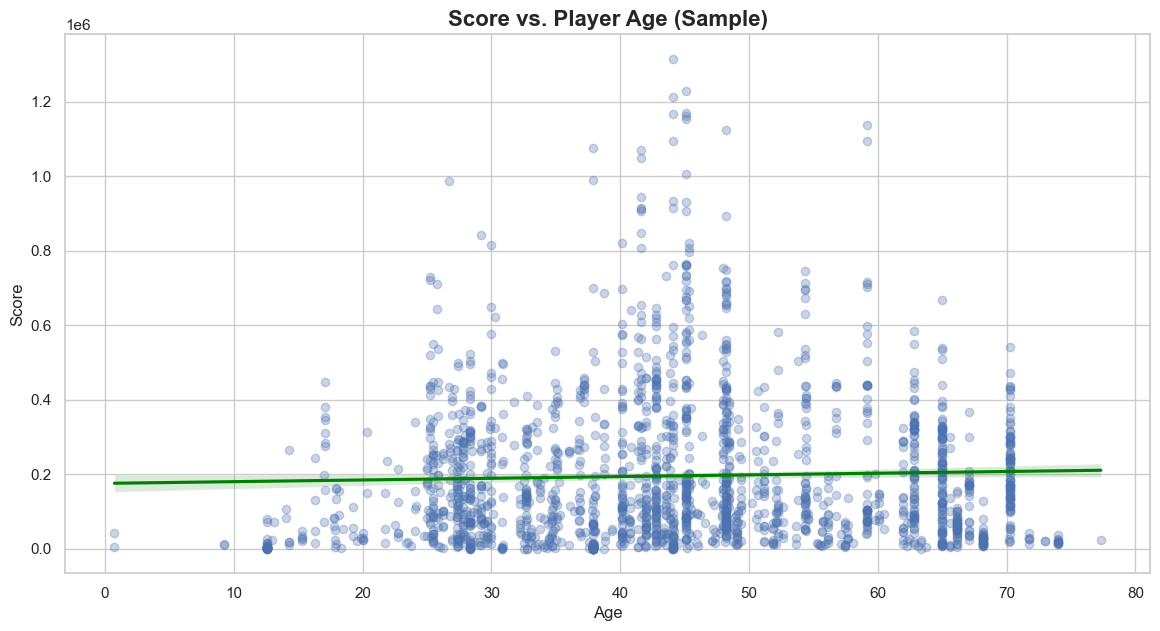

In [35]:
if 'df_cleaned' in locals():
    # --- Analysis by Age Group ---
    
    # Drop rows where age could not be calculated (because 'dob' was missing)
    age_df = df_cleaned.dropna(subset=['age']).copy()
    
    # Create age group categories for analysis
    bins = [0, 18, 25, 35, 45, 55, 100]
    labels = ['<18', '18-25', '26-35', '36-45', '46-55', '55+']
    age_df['age_group'] = pd.cut(age_df['age'], bins=bins, labels=labels, right=False)

    print(f"\n--- Analyzing {len(age_df)} records with available age data ---")

    plt.figure(figsize=(14, 8))
    sns.boxplot(x='age_group', y='score', data=age_df)
    plt.title('Score Distribution by Age Group', fontsize=16, weight='bold')
    plt.xlabel('Age Group')
    plt.ylabel('Score')
    plt.show()

    # --- Analysis by Age (Continuous) ---
    plt.figure(figsize=(14, 7))
    # Using a sample to keep the plot readable
    sns.regplot(x='age', y='score', data=age_df.sample(n=min(2000, len(age_df)), random_state=42),
                scatter_kws={'alpha':0.3}, line_kws={"color": "green"})
    plt.title('Score vs. Player Age (Sample)', fontsize=16, weight='bold')
    plt.xlabel('Age')
    plt.ylabel('Score')
    plt.show()